### 0: IMPORTING LIBRARIES AND SETTING THE SEEDS

In [208]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
import pytorch_lightning as pl
from typing import Tuple
import PIL
import random
from PIL import Image
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import csv
from torchmetrics.functional import accuracy
import numpy as np
import torchvision
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2
from torchvision import datasets
from torchmetrics.classification import Accuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint
import math
import os

In [209]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        - seed {int} : Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    pl.seed_everything(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(31)

### 1: DATA INSPECTION

#### 1.1: CREATION OF THE LABEL DICTIONARY

In [210]:
mapping_dict = {}

# Open the file in read mode.
with open('/kaggle/input/tiny-imagenet/tiny-imagenet-200/words.txt', 'r') as file:
    # Read each line from the file.
    for line in file:
        # Split the line into tokens based on whitespace.
        tokens = line.strip().split('\t')
        
        # Check if there are at least two tokens.
        if len(tokens) >= 2:
            # Extract the encoded label (left) and actual label (right).
            encoded_label, actual_label = tokens[0], tokens[1]
            
            # Add the mapping to the dictionary.
            mapping_dict[encoded_label] = actual_label

# Print the mapping dictionary.
#print(mapping_dict)


#### 1.2: DISPLAYING EXAMPLES OF THE DATASET

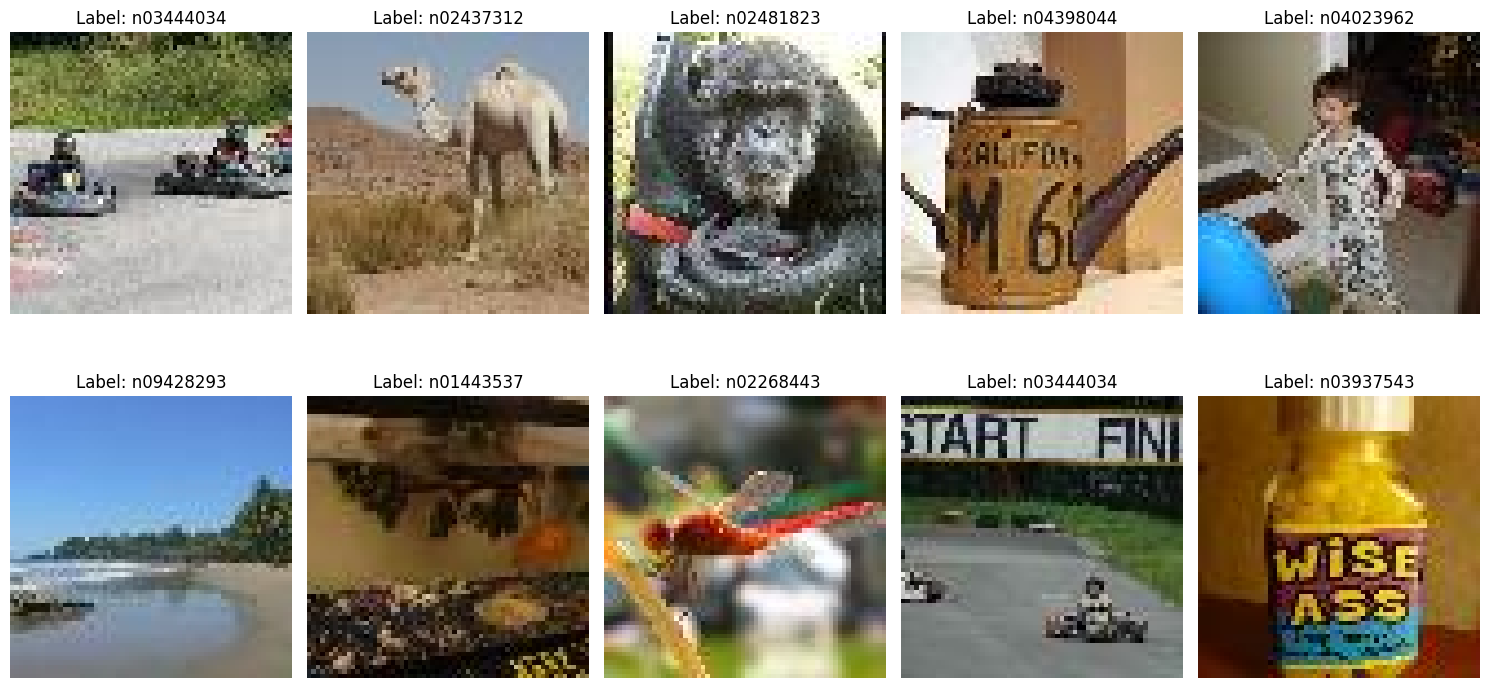

In [211]:
# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]
np.random.seed(31)

# Create a grid of 10 images with labels.
plt.figure(figsize=(15, 8))
for i in range(10):
    
    # Randomly select an image and its corresponding label.
    index = np.random.randint(len(dataset0))
    image, label = dataset0[index]

    # Display the image with its label
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  # Convert the PIL Image to a numpy array
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 1.3: DISPLAYING EXAMPLES OF THE DATASET WITH DECODED LABELS

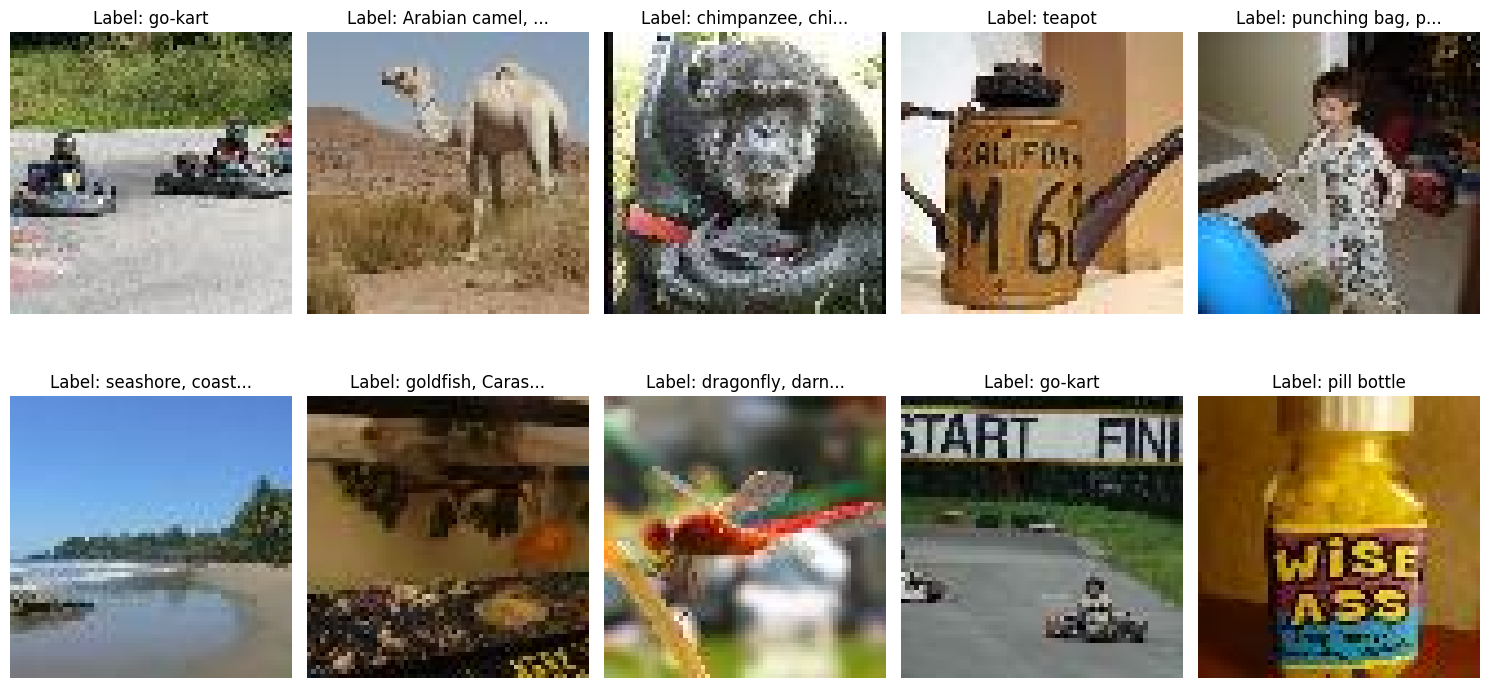

In [212]:
# Assuming you have already loaded the dataset using ImageFolder
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

np.random.seed(31)
# Create a grid of 10 images with labels
plt.figure(figsize=(15, 8))
for i in range(10):
    # Randomly select an image and its corresponding label
    index = np.random.randint(len(dataset0))
    image, encoded_label = dataset0[index]
    # Look up the actual label using the mapping dictionary
    actual_label = mapping_dict.get(class_names[encoded_label], "Unknown Label")
    
    # Trim the label if it exceeds the maximum length.
    actual_label_trimmed = actual_label[:15] + '...' if len(actual_label) > 15 else actual_label

    # Display the image with its label.
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  # Convert the PIL Image to a numpy array
    plt.title(f"Label: {actual_label_trimmed}", wrap=True)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 2: DATA-MODULE DEFINITION

#### 2.1: CUSTOMIZED TRAINING SET VERSION

In [213]:
class CustomTrainingDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomTrainingDataset, self).__init__(root, transform=transform)
        self.class_to_index = {cls: idx for idx, cls in enumerate(sorted(self.classes))}
        self.index_to_class = {idx: cls for cls, idx in self.class_to_index.items()}

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # Adjust the directory depth
        target_str = os.path.basename(os.path.dirname(os.path.dirname(path)))  # Remove two os.path.dirname

        # Convert string label to numerical index
        target = self.class_to_index[target_str]

        return sample, target

    def get_class_from_index(self, index):
        return self.index_to_class[index]


#### 2.2: CUSTOMIZED VALIDATION SET VERSION

In [214]:
class CustomValidationDataset(pl.LightningDataModule):
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.labels = self.load_labels()
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels.values())))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

    def load_labels(self):
        label_path = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/val_annotations.txt"
        labels = {}

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.split("\t")
            image_name, label = parts[0], parts[1]
            labels[image_name] = label

        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_name = f"val_{index}.JPEG"
        image_path = self.root / image_name

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Use get method to handle cases where the key is not present
        label_str = self.labels.get(image_name, 'Label not found')

        # Convert string label to numerical index
        label = self.label_to_index[label_str]

        return image, label

    def get_label_from_index(self, index):
        return self.index_to_label[index]


#### 2.3: GENERAL DATA-MODULE DEFINITION

In [215]:
class AViT_DataModule(pl.LightningDataModule):
    def __init__(self, train_data_dir, val_data_dir, batch_size, num_workers=4):
        super(AViT_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.val_data_dir = val_data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        # Load Train dataset using CustomTrainingDataset with the new directory structure
        self.train_dataset = CustomTrainingDataset(self.train_data_dir, transform=self.transform)

        # Load Validation dataset
        self.val_dataset = CustomValidationDataset(self.val_data_dir, transform=self.transform)

    def train_dataloader(self):
        # Return the DataLoader for the training dataset
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        # Return the DataLoader for the validation dataset
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)


#### 2.4: TESTING TRAINING AND VALIDATION DATALOADERS

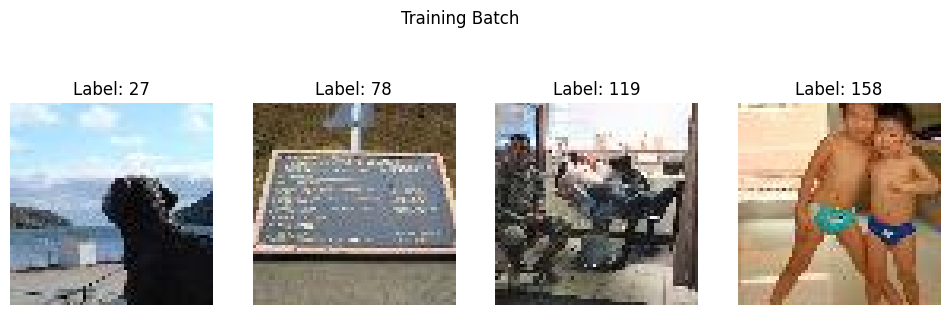

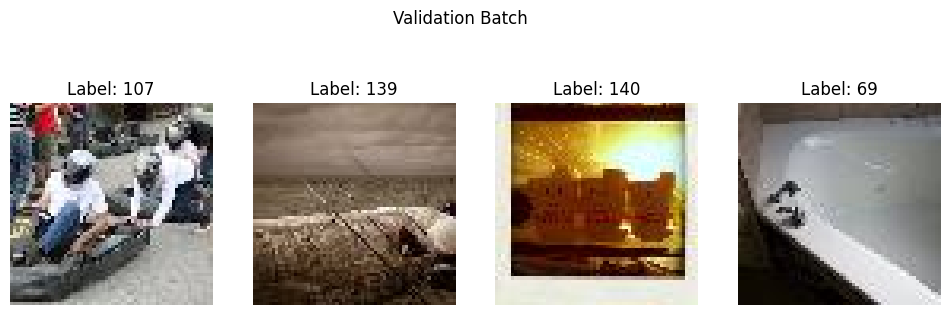

In [216]:
# Define the AViT_DataModule
data_module = AViT_DataModule(
    train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/",
    val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/",
    batch_size=4  # Adjust the batch size as needed
)

# Setup the dataloaders
data_module.setup()

# Get a batch from the training DataLoader
train_dataloader = data_module.train_dataloader()
train_batch = next(iter(train_dataloader))

# Get a batch from the validation DataLoader
val_dataloader = data_module.val_dataloader()
val_batch = next(iter(val_dataloader))

# Display images and labels
def show_images_labels(images, labels, title):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))
    fig.suptitle(title)

    for i, (img, label) in enumerate(zip(images, labels)):
        axs[i].imshow(transforms.ToPILImage()(img))
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')

    plt.show()

# Show training batch
show_images_labels(train_batch[0], train_batch[1], title='Training Batch')

# Show validation batch
show_images_labels(val_batch[0], val_batch[1], title='Validation Batch')


### 3: MODEL DEFINITION

#### 3.0: PATCHING FUNCTION DEFINITION

In [217]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

# Get a batch from the training DataLoader
train_dataloader = data_module.train_dataloader()
train_batch = next(iter(train_dataloader))

# Choose an image from the training batch
image_index = 0  # You can choose any index within the batch size
selected_image = train_batch[0][image_index].unsqueeze(0)  # Extract and unsqueeze to add batch dimension

# Assuming patches_reshaped is your tensor of patches
# and n_patches is the number of patches along one dimension

n_patches = 4  # Change this to match your actual number of patches
patch_size = 64 // n_patches  # Assuming image_size is the size of the original image

# Assuming patches_reshaped is your tensor of patches
# It should be of shape (batch_size, n_patches ** 2, patch_size ** 2, num_channels)

# Reshape patches_reshaped to (batch_size * n_patches ** 2, num_channels, patch_size, patch_size)
patches_reshaped = patches_reshaped.view(-1, 3, patch_size, patch_size)

# Display the original image
fig, axs = plt.subplots(1, n_patches ** 2 + 1, figsize=(15, 5))

# Display the original image
axs[0].imshow(selected_image[0].permute(1, 2, 0))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display patches
for i in range(n_patches ** 2):
    axs[i + 1].imshow(patches_reshaped[i].permute(1, 2, 0))
    axs[i + 1].set_title(f'Patch {i + 1}')
    axs[i + 1].axis('off')

plt.show()


#### 3.1: POSITIONAL EMBEDDING DEFINITION

In [218]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

#### 3.2: MULTI-HEAD SELF-ATTENTION DEFINITION

In [219]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

#### 3.3: ViT BLOCK DEFINITION

In [220]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

#### 3.4: ViT MODEL DEFINITION

In [221]:
class MyViT(nn.Module):
        
    def __init__(self, chw, n_patches, n_blocks, hidden_d, n_heads, out_d):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution
    

#### 3.5: GENERAL AViT MODEL DEFINITION

In [222]:
class AViT_Model(MyViT, pl.LightningModule):
    
    def __init__(self, input_d, n_patches, n_blocks, hidden_d, n_heads, out_d):
        
        super(AViT_Model, self).__init__(input_d, n_patches, n_blocks, hidden_d, n_heads, out_d)

        # Definition of the Weighted Cross Entropy Loss + Label Smoothing.
        self.loss = CrossEntropyLoss()

        # Definition of Accuracy, F1Score, Precision and Recall Metrics.
        self.acc = Accuracy(task="multiclass", num_classes=out_d)
        self.f1score = MulticlassF1Score(num_classes=out_d, average='macro')
        self.precision = MulticlassPrecision(num_classes=out_d, average='macro')
        self.recall = MulticlassRecall(num_classes=out_d, average='macro')
        
        # Definition of lists to be used in the "on_ ... _epoch_end" functions.
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
    
    def _step(self, batch):
        
        # Common computation of the metrics among Training, Validation and Test Set.
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y)
        acc = self.acc(preds, y)
        f1score = self.f1score(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        
        return loss, acc, f1score, precision, recall
    
    
    def training_step(self, batch, batch_idx):
        
        # Compute the Training Loss and Accracy.
        loss, acc, _, _, _ = self._step(batch)

        # Create a dictionary to represent the output of the training step.
        training_step_output = {
            "train_loss": loss.item(),
            "train_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.training_step_outputs.append(training_step_output)

        # Perform logging.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        
        # Compute the Validation Loss and Accuracy.
        loss, acc, _, _, _ = self._step(batch)

        # Create a dictionary to represent the output of the validation step.
        validation_step_output = {
            "val_loss": loss.item(),
            "val_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.validation_step_outputs.append(validation_step_output)

        # Perform logging.
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["val_loss"] for item in self.validation_step_outputs]).mean()
        acc_tot = torch.tensor([item["val_acc"] for item in self.validation_step_outputs]).mean()

        # Log the mean values.
        self.log("val_loss", loss_tot)
        self.log("val_acc", acc_tot)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Validation Loss -> {loss_tot}'
        message_accuracy = f'      Validation Accuracy -> {acc_tot}'
        print(message_loss + message_accuracy)

        # Clear the list to free memory.
        self.validation_step_outputs.clear()

    
    def configure_optimizers(self):
        
        # Configure the Adam Optimizer.
        optimizer = optim.Adam(self.parameters(), lr=5e-3)
        
        return optimizer
        

### 4: MODEL TRAINING

#### 4.1: CALLBACKS DEFINITION

In [223]:
# Checkpoint CallBack Definition.
my_checkpoint_call = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints/",
    filename="Best_Model",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

# Learning Rate CallBack Definition.
my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")

# Early Stopping CallBack Definition.
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min", min_delta=0.001)

# Progress Bar CallBack Definition.
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)

# TensorBoardLogger CallBack Definition.
tb_logger = TensorBoardLogger("/kaggle/working/logs", name="AViT")

# CSV CallBack Definition.
csv_logger = CSVLogger("/kaggle/working/logs", name="AViT")


#### 4.2: MODEL INSTANTIATION & TRAINING

In [224]:
# Initialize the model and data module.

# Image Flattened Dimension = 64*64*3 = 4096*3 = 12288
# n_patches = 16
# chw = (3, 64, 64)
# patch_size = (3, 64/16, 64/16) = (3, 4, 4) = (#channels, #h_patch, #w_patch)
# 256 patch of 48 elements = 256 * 48 = 12288
# hidden_d = linear mapping output dimension

# n_block = how many times the Transformer Block is repeated. 
# n_heads = how many times we repeat self-attention.
# out_d = number of output classes.

model = AViT_Model((3, 64, 64), 
                   n_patches=16, 
                   n_blocks=2, 
                   hidden_d=8, 
                   n_heads=2, 
                   out_d = 200)

datamodule = AViT_DataModule(train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", 
                             val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/", 
                             batch_size=32)

# Setup the dataloaders
data_module.setup()

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=tb_logger,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)


In [ ]:
# Train the model
result = trainer.fit(model, datamodule)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working/checkpoints/ exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 5.298102378845215      Validation Accuracy -> 0.0


Training: |          | 0/? [00:00<?, ?it/s]

### 5: BEST MODEL EXTRAPOLATION

In [ ]:
best_model_path = my_checkpoint_call.best_model_path
best_model = AViT_Model.load_from_checkpoint(checkpoint_path=best_model_path, 
                                             (3, 64, 64), 
                                             n_patches=16, 
                                             n_blocks=2, 
                                             hidden_d=8, 
                                             n_heads=2, 
                                             out_d = 200)

### 6: SAVING THE BEST MODEL

In [ ]:
# Specify the path where you want to save the model
model_path = f"/kaggle/working/best_model_acc_{result[0]['val_acc']:.5f}.pth"

# Save the model's state dict to the specified file
torch.save(best_model.state_dict(), model_path)